In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import torch.nn as nn

In [2]:
# Path to the chest-ct-segmentation dataset folder
data_dir = "dataset\Lucchi++" 
train_images_dir = os.path.join(data_dir, "Train_In")
train_masks_dir = os.path.join(data_dir, "Train_Out")
test_images_dir = os.path.join(data_dir, "Test_In")
test_masks_dir = os.path.join(data_dir, "Test_Out")
PATCH_SIZE = 128

i = 0
# Prepare the training data, Append image and corresponding mask paths
train_data = []
for image_file in os.listdir(train_images_dir):
    image_path = os.path.join(train_images_dir, image_file)
    mask_path = os.path.join(train_masks_dir, f"{i}.png")
    i += 1
    train_data.append(
    { 
        "image" : image_path, 
        "annotation" : mask_path
    })

i = 0
# Prepare the test data, Append image and corresponding mask paths
test_data = []
for image_file in os.listdir(test_images_dir):
    image_path = os.path.join(test_images_dir, image_file)
    mask_path = os.path.join(test_masks_dir, f"{i}.png")
    i += 1
    test_data.append(
    { 
        "image" : image_path, 
        "annotation" : mask_path
    })
print(train_data)

[{'image': 'dataset\\Lucchi++\\Train_In\\mask0000.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\0.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0001.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\1.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0002.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\2.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0003.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\3.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0004.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\4.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0005.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\5.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0006.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\6.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0007.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\7.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0008.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\8.png'}, {'image': 'dataset

In [3]:
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        
        # Encoder (downsampling)
        self.encoder = nn.Sequential(
            self.conv_block(3, 32, stride=2),
            self.conv_block(32, 64, stride=2),
            self.conv_block(64, 128, stride=2),
            self.conv_block(128, 256, stride=2)
        )
        
        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            self.upconv_block(256, 128),
            self.upconv_block(128, 64),
            self.upconv_block(64, 32),
            self.upconv_block(32, 32)
        )
        
        # Final classification layer
        self.final = nn.Conv2d(32, num_classes, kernel_size=3, padding=1)
        
    def conv_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        features = []
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            features.append(x)
        
        # Decoder
        for i, decoder_layer in enumerate(self.decoder):
            x = decoder_layer(x)
            if i < len(self.decoder) - 1:
                x = x + features[-i-2]  # Skip connection
        
        # Final classification
        x = self.final(x)
        return x

In [4]:
# Custom Dataset class
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Load image and mask
        image = cv2.imread(self.data_list[idx]["image"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.data_list[idx]["annotation"], cv2.IMREAD_GRAYSCALE)

        # Resize image and mask to 1024x768
        image = cv2.resize(image, (1024, 768))
        mask = cv2.resize(mask, (1024, 768))

        # Split image and mask into 64x64 patches
        patch_size = PATCH_SIZE
        image_patches = []
        mask_patches = []

        for i in range(0, 1024, patch_size):
            for j in range(0, 768, patch_size):
                image_patch = image[i:i+patch_size, j:j+patch_size]
                mask_patch = mask[i:i+patch_size, j:j+patch_size]
                if image_patch.size > 0 and mask_patch.size > 0:
                    # Transpose image patch to (C, H, W) format
                    image_patch = image_patch.transpose(2, 0, 1)
                    image_patches.append(image_patch)
                    mask_patches.append(mask_patch)

        # Convert lists to numpy arrays and normalize
        image_patches = np.array(image_patches, dtype=np.float32) / 255.0
        mask_patches = np.array(mask_patches, dtype=np.float32) / 255.0

        # Convert to tensors
        image_patches = torch.from_numpy(image_patches)
        mask_patches = torch.from_numpy(mask_patches).unsqueeze(1)

        return image_patches, mask_patches

def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    # Convert predictions to binary
    pred_mask = (pred_mask > threshold).float()

    # Calculate intersection and union
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection

    # Calculate IoU
    iou = (intersection + 1e-7) / (union + 1e-7)

    # Calculate Dice coefficient
    dice = (2. * intersection + 1e-7) / (pred_mask.sum() + true_mask.sum() + 1e-7)

    return iou.item(), dice.item()

# Training function
def train_model(model, train_loader, val_loader, num_epochs=50, device="cuda"):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    best_val_iou = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou = 0
        train_dice = 0
        num_batches = 0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            images = images.view(-1, 3, PATCH_SIZE, PATCH_SIZE)
            masks = masks.view(-1, 1, PATCH_SIZE, PATCH_SIZE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            # Calculate metrics
            batch_iou, batch_dice = calculate_metrics(torch.sigmoid(outputs), masks)

            train_loss += loss.item()
            train_iou += batch_iou
            train_dice += batch_dice
            num_batches += 1

        avg_train_loss = train_loss / num_batches
        avg_train_iou = train_iou / num_batches
        avg_train_dice = train_dice / num_batches

        # Validation phase
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        num_val_batches = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                images = images.view(-1, 3, PATCH_SIZE, PATCH_SIZE)
                masks = masks.view(-1, 1, PATCH_SIZE, PATCH_SIZE)

                outputs = model(images)
                loss = criterion(outputs, masks)

                # Calculate metrics
                batch_iou, batch_dice = calculate_metrics(torch.sigmoid(outputs), masks)

                val_loss += loss.item()
                val_iou += batch_iou
                val_dice += batch_dice
                num_val_batches += 1

        avg_val_loss = val_loss / num_val_batches
        avg_val_iou = val_iou / num_val_batches
        avg_val_dice = val_dice / num_val_batches

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training - Loss: {avg_train_loss:.4f}, IoU: {avg_train_iou:.4f}, Dice: {avg_train_dice:.4f}')
        print(f'Validation - Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}, Dice: {avg_val_dice:.4f}')

        # Save best model based on IoU
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            # torch.save(model.state_dict(), 'best_model_iou.pth')

        # Also save based on loss if needed
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # torch.save(model.state_dict(), 'best_model_loss.pth')

        print('-' * 60)

# Inference function
def predict(model, image_path, device="cuda"):
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1024, 768))
    
    # Parameters for overlapping patches
    patch_size = PATCH_SIZE
    overlap = patch_size // 2  # 50% overlap
    
    # Calculate steps with overlap
    h_steps = int(np.ceil((768 - patch_size) / (patch_size - overlap))) + 1
    w_steps = int(np.ceil((1024 - patch_size) / (patch_size - overlap))) + 1
    
    patches_list = []
    patch_positions = []  # Store positions for reconstruction
    
    # Extract overlapping patches
    for i in range(h_steps):
        for j in range(w_steps):
            # Calculate patch coordinates
            y_start = min(i * (patch_size - overlap), 768 - patch_size)
            x_start = min(j * (patch_size - overlap), 1024 - patch_size)
            
            # Extract patch
            patch = image[y_start:y_start+patch_size, x_start:x_start+patch_size]
            
            # Normalize and convert channel order
            patch = patch / 255.0
            patch = patch.transpose(2, 0, 1)
            patches_list.append(patch)
            patch_positions.append((y_start, x_start))
    
    # Convert to tensor
    patches_array = np.stack(patches_list)
    patches_tensor = torch.from_numpy(patches_array).float().to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(patches_tensor)
        pred_masks = torch.sigmoid(outputs) > 0.5
    
    # Initialize weight and prediction maps
    weight_map = np.zeros((768, 1024))  # here 768 * 1024 is Lucchi++ image size
    pred_map = np.zeros((768, 1024))
    
    # Create weight kernel for blending
    y, x = np.mgrid[0:patch_size, 0:patch_size]
    weight_kernel = np.exp(-((x - patch_size/2)**2 + (y - patch_size/2)**2) / (2*(patch_size/4)**2))
    
    # Reconstruct full mask with weighted averaging
    for idx, (y_start, x_start) in enumerate(patch_positions):
        mask_patch = pred_masks[idx, 0].cpu().numpy()
        
        # Apply weight kernel
        weighted_patch = mask_patch * weight_kernel
        
        # Add to prediction and weight maps
        y_end = min(y_start + patch_size, 768)
        x_end = min(x_start + patch_size, 1024)
        h, w = y_end - y_start, x_end - x_start
        
        pred_map[y_start:y_end, x_start:x_end] += weighted_patch[:h, :w]
        weight_map[y_start:y_end, x_start:x_end] += weight_kernel[:h, :w]
    
    # Normalize by weights
    full_mask = np.divide(pred_map, weight_map, where=weight_map > 0)
    full_mask = (full_mask > 0.5).astype(np.float32)
    
    return full_mask



In [21]:
# Create datasets
train_dataset = SegmentationDataset(train_data)
test_dataset = SegmentationDataset(test_data)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationModel(num_classes=1).to(device)


In [23]:
# # Train model
train_model(model, train_loader, test_loader, num_epochs=50, device=device)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


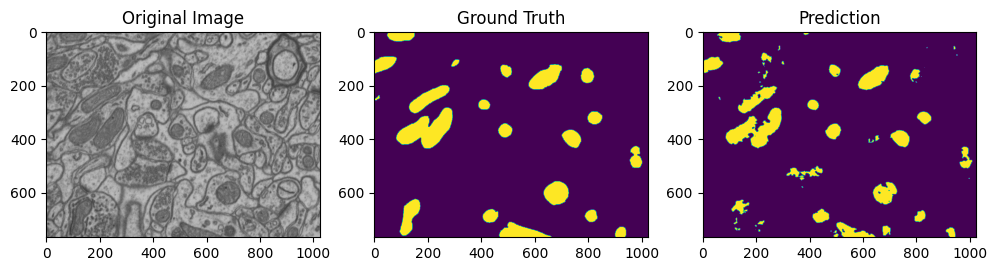

In [9]:
# https://huggingface.co/CompVis/ldm-super-resolution-4x-openimages1
# Example inference
test_image_path = test_data[0]["image"]
pred_mask = predict(model, test_image_path)

# # Visualize results
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cv2.imread(test_image_path))
plt.title('Original Image')
plt.subplot(132)
plt.imshow(cv2.imread(test_data[0]["annotation"], cv2.IMREAD_GRAYSCALE))
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(pred_mask)
plt.title('Prediction')
plt.show()



In [10]:
# 保存模型
torch.save(model.state_dict(), "overlaping_unet_segmentation_Lucchi++.pth")

In [ ]:
# load from oxford_segmentation_models.pth
import torch

def load_model(model_path, num_classes, device):
    # Create an instance of your model
    model = SegmentationModel(num_classes)
    
    # Load the state dict
    state_dict = torch.load(model_path, map_location=device)
    
    # Load the state dict into your model
    model.load_state_dict(state_dict)
    
    # Move the model to the specified device
    model = model.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 1 
model_path = "simple_unet_segmentation.pth"

model = load_model(model_path, num_classes, device)

TypeError: SegmentationModel.__init__() missing 1 required positional argument: 'num_classes'